# Chatbot with message summarization


In [1]:
%pip install --quiet -U langchain_groq langchain_core langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.9/130.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 1.9 MB/s eta 0:00:00


In [2]:
from google.colab import userdata
apikey = userdata.get('GROQ_API_KEY')

In [3]:
from langchain_groq import ChatGroq
llm = ChatGroq(model= 'llama-3.3-70b-versatile', temperature = 0, api_key=apikey)

In [5]:
from langgraph.graph import MessagesState

class State(MessagesState):
    summary : str

In [6]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

# Define the logic to call the model
def call_model(state: State) -> State:

    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:

        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]

    else:
        messages = state["messages"]

    response = llm.invoke(messages)
    return {"messages": response}

In [7]:
def summarize_conversation(state: State):

    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt
    if summary:

        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )

    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = llm.invoke(messages)

    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

In [8]:
from langgraph.graph import END
# Determine whether to end or summarize the conversation
def should_continue(state: State):

    """Return the next node to execute."""

    messages = state["messages"]

    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"

    # Otherwise we can just end
    return END

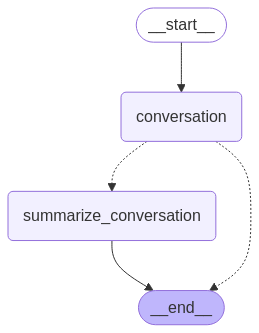

In [9]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.state import CompiledStateGraph

# Define a new graph
workflow: StateGraph = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory: MemorySaver = MemorySaver()
graph: CompiledStateGraph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Zeeshan")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like cricket!")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hello Zeeshan! It's nice to meet you. Is there something I can help you with or would you like to chat?
================================== Ai Message ==================================

Your name is Zeeshan.
================================== Ai Message ==================================

Cricket is an exciting sport. Who's your favorite team or player? Are you a fan of international cricket, or do you follow a specific domestic league like the IPL or PSL?


In [11]:
input_message = HumanMessage(content="who is best player in odi?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

That's a subjective question, and opinions may vary depending on personal preferences and team loyalties. However, according to various cricket statistics and expert opinions, some of the top ODI players of all time include:

1. Sachin Tendulkar (India) - Regarded by many as the greatest batsman in ODI history.
2. Vivian Richards (West Indies) - A dominant force in the 1980s, known for his aggressive batting style.
3. AB de Villiers (South Africa) - A versatile player who excelled in all aspects of the game.
4. Virat Kohli (India) - One of the most successful ODI batsmen in recent years, known for his consistency and ability to chase down targets.
5. Chris Gayle (West Indies) - A powerful hitter who has dominated ODI cricket with his explosive batting.

As for the current best player in ODI, it's hard to look past Babar Azam (Pakistan) or Virat Kohli (India), who have been consistently performing at a hig

In [12]:
graph.get_state(config).values.get("summary","")

"Here's a summary of our conversation:\n\n* We introduced ourselves, and I learned that your name is Zeeshan.\n* You mentioned that you like cricket, and we started discussing the sport.\n* You asked about the best player in ODI cricket, and I provided a list of some of the top ODI players of all time, including Sachin Tendulkar, Vivian Richards, AB de Villiers, Virat Kohli, and Chris Gayle.\n* I also mentioned that Babar Azam and Virat Kohli are currently among the top ODI players.\n\nLet me know if you'd like to continue the conversation or if you have any other questions!"